---
title: "Data Cleaning"
format:
    html: 
        code-fold: true
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Data Merge

The data cleaning process begins with loading multiple WHO datasets related to chronic disease indicators, including blood glucose levels, BMI, diabetes prevalence, and hypertension statistics. These datasets, originally stored as separate CSV files, are consolidated into a single DataFrame for streamlined analysis. All the raw datas can be found from [WHO Data](https://drive.google.com/drive/folders/1puoOCSccRjK5w9MeDEmJUJ4dbnpPkFhC?usp=sharing).

The merging process involves reading each CSV file into a DataFrame using Pandas and concatenating them into a unified dataset, ensuring consistent column structures. After merging, the dataset is inspected to verify the integrity of the combined data. The columns include key health metrics, geographic and temporal dimensions, demographic details, and statistical values with confidence intervals.

In [3]:
who_files = [
    'who_blood_glucose_age_std.csv',
    'who_blood_glucose_crude.csv',
    'who_bmi_data.csv',
    'who_diabetes_prevalence_age_std.csv',
    'who_diabetes_prevalence_crude.csv',
    'who_hypertension_control.csv',
    'who_hypertension_prevalence.csv',
    'who_hypertension_treatment.csv'
]

# Merge all the datasets
who_dataframes = [pd.read_csv(f'data/raw-data/{file}') for file in who_files]
who_data = pd.concat(who_dataframes, ignore_index=True)

# Check the data sample
print("WHO Data Sample:", who_data.head(), sep="\n")


WHO Data Sample:
     Id IndicatorCode SpatialDimType SpatialDim TimeDimType  \
0   951   NCD_GLUC_01        COUNTRY        LAO        YEAR   
1  3231   NCD_GLUC_01        COUNTRY        USA        YEAR   
2  3454   NCD_GLUC_01        COUNTRY        STP        YEAR   
3  3479   NCD_GLUC_01        COUNTRY        COG        YEAR   
4  5816   NCD_GLUC_01        COUNTRY        CYP        YEAR   

  ParentLocationCode   ParentLocation Dim1Type  TimeDim      Dim1  ...  \
0                WPR  Western Pacific      SEX     1982  SEX_FMLE  ...   
1                AMR         Americas      SEX     2002   SEX_MLE  ...   
2                AFR           Africa      SEX     2011   SEX_MLE  ...   
3                AFR           Africa      SEX     1992  SEX_FMLE  ...   
4                EUR           Europe      SEX     1994   SEX_MLE  ...   

  DataSourceDim             Value  NumericValue      Low     High  Comments  \
0           NaN  4.54 [3.35-5.73]       4.53983  3.34849  5.72962       NaN   
1

## Before Cleaning Visualization

This part shows a pairplot visualized the pairwise relationships and distributions of selected numerical features from the raw WHO dataset. This visualization includes scatterplots to highlight relationships between variables and histograms along the diagonal to illustrate individual feature distributions. The pairplot reveals several important insights. 

The diagonal histograms show that variables such as `NumericValue` and `High` have skewed distributions, while others like `Low` exhibit a more uniform spread with noticeable peaks. The scatterplots indicate strong positive correlations among `NumericValue`, `Low`, and `High`, suggesting potential redundancy in these features, as `Low` and `High` likely represent confidence intervals derived from `NumericValue`. Additionally, some points deviate from the main clusters in the scatterplots, potentially indicating outliers or unique cases that could influence downstream analysis. This visualization provides a valuable overview of feature relationships and distribution patterns, serving as a basis for further preprocessing, such as handling multicollinearity and addressing skewness, to prepare the data for modeling.

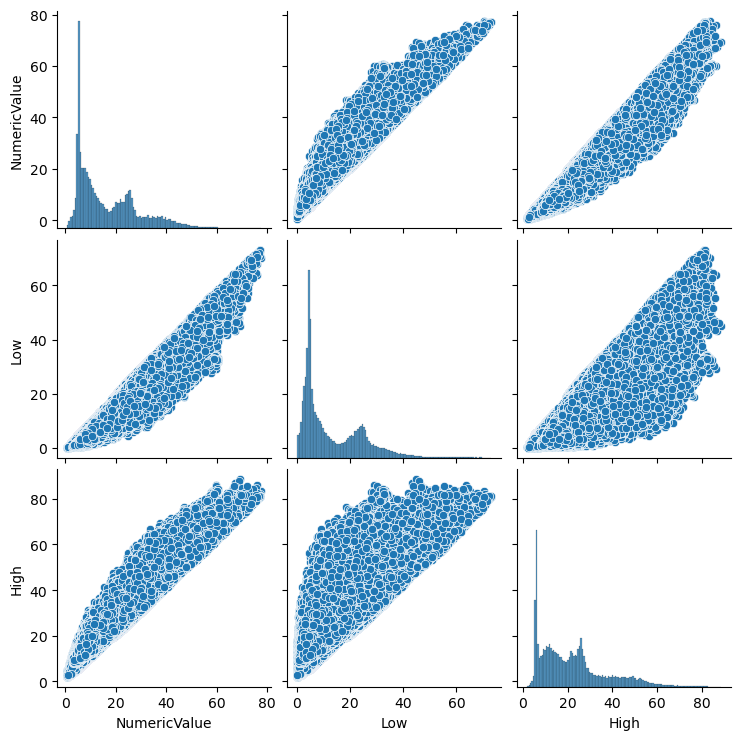

In [4]:
numeric_columns = ['NumericValue', 'Low', 'High']

# Create a pairplot
sns.pairplot(who_data[numeric_columns])
plt.show()

## Filter Relevant Columns

To streamline the dataset and retain only relevant information for analysis, key columns from the original WHO dataset are selected. These columns include health indicators (`IndicatorCode`), geographic details (`SpatialDim` and `ParentLocation`), temporal data (`TimeDim`), demographic attributes (`Dim1`), and corresponding health metric values (`NumericValue`). 

The selected columns are renamed for clarity and consistency, using more intuitive names such as `indicator`, `location`, `region`, `year`, `Gender`, and `value`. This restructuring simplifies data referencing in subsequent analysis stages while preserving essential health statistics needed for machine learning and statistical modeling.

In [5]:
# Filter out the required columns
who_data_clean = who_data[['IndicatorCode', 'SpatialDim', 'ParentLocation', 
                           'TimeDim', 'Dim1', 'NumericValue']].copy()

# Rename columns
who_data_clean.rename(columns={
    'IndicatorCode': 'indicator',
    'SpatialDim': 'location',  
    'ParentLocation': 'region',  
    'TimeDim': 'year',
    'Dim1': 'Gender',
    'NumericValue': 'value'
}, inplace=True)

## Data Cleaning and Indicator Filtering

This section refines the WHO dataset by removing duplicate records to ensure data integrity and avoid redundant entries. Data types are corrected for key columns: `year` is converted to integers and `value` to floats, enabling precise numerical analysis. 

Next, only relevant health indicators are retained based on their significance to chronic disease research. These indicators include BMI, diabetes prevalence (both crude and age-standardized), and various measures related to hypertension such as prevalence, control rates, and treatment coverage. This targeted filtering reduces dataset complexity while preserving essential health metrics for subsequent data analysis and machine learning tasks.

In [6]:
who_data_clean.drop_duplicates(inplace=True)

# Fix data types
who_data_clean = who_data_clean.astype({
    'year': 'int',
    'value': 'float'
})

# Filter out useful indicators
relevant_indicators = [
    'NCD_BMI_MEAN', 
    'NCD_DIABETES_PREVALENCE_CRUDE', 
    'NCD_DIABETES_PREVALENCE_AGESTD',
    'NCD_HYP_PREVALENCE_A',
    'NCD_HYP_CONTROL_A',
    'NCD_HYP_TREATMENT_A'
]

who_data_clean = who_data_clean[who_data_clean['indicator'].isin(relevant_indicators)]

## Indicator and Gender Mapping

This section standardizes the WHO dataset by mapping complex indicator codes and gender labels to more intuitive and readable names. A dictionary-based mapping replaces original WHO indicator codes with simplified labels such as `BMI`, `Diabetes_Crude`, and `Hypertension_Control`. Similarly, gender codes like `SEX_FMLE`, `SEX_MLE`, and `SEX_BTSX` are converted to `Female`, `Male`, and `Both`, improving dataset readability and facilitating subsequent analysis.

In [7]:
# Mapping dictionary for indicator values
indicator_mapping = {
    'NCD_BMI_MEAN': 'BMI',
    'NCD_DIABETES_PREVALENCE_CRUDE': 'Diabetes_Crude',
    'NCD_DIABETES_PREVALENCE_AGESTD': 'Diabetes_AgeStd',
    'NCD_HYP_PREVALENCE_A': 'Hypertension_Prevalence',
    'NCD_HYP_CONTROL_A': 'Hypertension_Control',
    'NCD_HYP_TREATMENT_A': 'Hypertension_Treatment'
}

# Replace long-form indicator names with short forms
who_data_clean['indicator'] = who_data_clean['indicator'].map(indicator_mapping)

# Mapping dictionary for Gender values
Gender_mapping = {
    'SEX_FMLE': 'Female',
    'SEX_MLE': 'Male',
    'SEX_BTSX': 'Both'
}

# Replace Gender codes with readable labels
who_data_clean['Gender'] = who_data_clean['Gender'].map(Gender_mapping)

## Data Aggregation and Health Risk Classification

The data aggregation process involved grouping the cleaned WHO dataset by `location`, `year`, `Gender`, and `indicator`, computing the average values for each indicator. This aggregation reduced redundancy and ensured each unique combination of location, year, and gender had a single entry. The reshaping of the dataset through the `pivot` function transformed indicator names into separate columns, simplifying feature extraction for model training. 

To support supervised learning tasks, two target labels were generated: `risk_level` for binary classification and `health_status` for multiclass classification. The `risk_level` label was determined based on BMI, following the WHO's classification[@nhlbi_bmi]: individuals with a BMI of 25 or above were labeled as high risk (value of 1), indicating overweight or obesity, while those with a BMI below 25 were labeled as low risk (value of 0).

The `health_status` label incorporated both BMI and crude diabetes prevalence to capture a more detailed health risk profile. Individuals were classified as "High Risk" if their BMI was 30 or higher, indicating obesity, or if their Diabetes_Crude value was 15 or above, signaling critical public health concerns. Those with a BMI between 25 and 30, coupled with a Diabetes_Crude value between 10 and 15, were categorized as "Moderate Risk," reflecting an elevated but not severe health risk. Individuals with a BMI below 25 and a Diabetes_Crude value under 10 were labeled as "Low Risk," indicating relatively healthy conditions.

These classification thresholds align with established clinical guidelines. BMI alone, though commonly used, does not fully capture chronic disease risks, as some individuals with normal BMI might still face metabolic health issues. Including diabetes prevalence compensates for this limitation by providing a direct measure of a critical chronic disease. Combining these indicators allows for a more robust, comprehensive classification, enabling both binary and multiclass predictive modeling.

In [8]:
# Aggregate by location, year, gender and indicator
grouped_data = who_data_clean.groupby(
    ["location", "year", "Gender", "indicator"]
).agg(
    avg_value=("value", "mean")  # Get the mean of value
).reset_index()

# Convert indicator to columns
pivoted_data = grouped_data.pivot(
    index=["location", "year", "Gender"],  # location, year and Gender as indexes
    columns="indicator", # indicator converted to columns
    values="avg_value" # Indicator value
).reset_index()

# Create a binary target column (risk level: based on BMI)
pivoted_data['risk_level'] = pivoted_data.apply(
    lambda row: 1 if row['BMI'] >= 25 else 0, axis=1
)

In [9]:
def classify_combined_features(row):
    if row['BMI'] >= 30 or row['Diabetes_Crude'] >= 15:
        return "High Risk"
    elif (25 <= row['BMI'] < 30) and (10 <= row['Diabetes_Crude'] < 15):
        return "Moderate Risk"
    else:
        return "Low Risk"

pivoted_data['health_status'] = pivoted_data.apply(classify_combined_features, axis=1)

print(pivoted_data['health_status'].value_counts())

health_status
Low Risk         23599
High Risk         4796
Moderate Risk     2519
Name: count, dtype: int64


## Mapping Locations to Regions

This section establishes a mapping between countries (`location`) and their corresponding regions (`region`) using the original WHO dataset. The process starts by extracting unique combinations of `SpatialDim` (location) and `ParentLocation` (region) from the raw data. These mappings are cleaned and renamed for clarity.

Next, the cleaned WHO dataset (`pivoted_data`) is merged with this mapping to assign each country its respective region. A validation step follows, checking for any unmatched locations. If regions are missing, the corresponding countries are listed for further inspection. This ensures that each country's data is accurately linked to its geographic context, enhancing the dataset's usability for regional health analysis.

In [10]:
# Extract the mapping relationship between location and region
location_region_mapping = who_data[['SpatialDim', 'ParentLocation']].drop_duplicates()

# Rename columns
location_region_mapping.rename(columns={
    'SpatialDim': 'location',
    'ParentLocation': 'region'
}, inplace=True)

print("Location-Region Mapping Sample:", location_region_mapping.head(), sep="\n")

pivoted_data = pivoted_data.merge(location_region_mapping, how='left', on='location')

# Check for unmatched regions
missing_regions = pivoted_data[pivoted_data['region'].isnull()]['location'].unique()
if len(missing_regions) > 0:
    print(f"Missing regions for the following countries: {missing_regions}")
else:
    print("All regions mapped successfully.")

Location-Region Mapping Sample:
  location           region
0      LAO  Western Pacific
1      USA         Americas
2      STP           Africa
3      COG           Africa
4      CYP           Europe
Missing regions for the following countries: ['AFR' 'AMR' 'EMR' 'EUR' 'GLOBAL' 'SEAR' 'UNSDG_AUSTRALIANEWZEALAND'
 'UNSDG_CENTRALASIASOUTHERNASIA' 'UNSDG_EASTERNASIASOUTHEASTERNASIA'
 'UNSDG_EUROPENORTHERNAMR' 'UNSDG_LAC' 'UNSDG_OCEANIAexAUSNZL'
 'UNSDG_SUBSAHARANAFRICA' 'UNSDG_WESTERNASIANORTHERNAFR' 'WB_HI' 'WB_LI'
 'WB_LMI' 'WB_UMI' 'WPR']


## Data Export  

In the final step of the data cleaning process, missing values are removed from the dataset to ensure data integrity and consistency. The cleaned dataset (`pivoted_data`) is then reordered for clarity, placing essential columns like `location`, `region`, `year`, `Gender`, `BMI`, `risk_level`, and `health_status` at the beginning. This reorganization improves readability and facilitates easier access during data analysis and modeling.  

The processed dataset is saved as `who_pivoted_data_with_classes.csv`, ensuring that the final cleaned data is well-structured, labeled, and ready for further analysis, including supervised and unsupervised learning tasks. This comprehensive cleaning workflow guarantees a high-quality dataset suitable for deriving meaningful insights into chronic disease risk factors. The processed data can be found from [WHO Processed Data](https://drive.google.com/drive/folders/1veorwdqbAE-UfspMBmguK7fgOq9DS5sj?usp=sharing).

In [12]:
pivoted_data.dropna(inplace=True)

pivoted_data = pivoted_data[['location', 'region', 'year', 'Gender', 'BMI', 
                             'risk_level', 'health_status'] + 
                             [col for col in pivoted_data.columns if col not in 
                             ['location', 'region', 'year', 'Gender', 'BMI', 
                             'risk_level', 'health_status']]]

print(pivoted_data.head())

pivoted_data.to_csv('data/processed-data/who_pivoted_data_with_classes.csv', index=False)
print("Pivoted data saved in the desired column order!")

   location                 region  year  Gender   BMI  risk_level  \
45      AFG  Eastern Mediterranean  1990    Both  20.6           0   
46      AFG  Eastern Mediterranean  1990  Female  20.8           0   
47      AFG  Eastern Mediterranean  1990    Male  20.4           0   
48      AFG  Eastern Mediterranean  1991    Both  20.8           0   
49      AFG  Eastern Mediterranean  1991  Female  21.0           0   

   health_status  Diabetes_AgeStd  Diabetes_Crude  Hypertension_Control  \
45      Low Risk        12.234075       10.108605                   3.3   
46      Low Risk        12.592865       10.339980                   3.9   
47      Low Risk        11.830505        9.861665                   2.6   
48      Low Risk        12.454725       10.288580                   3.4   
49      Low Risk        12.818725       10.535560                   4.0   

    Hypertension_Prevalence  Hypertension_Treatment  
45                     35.5                    19.5  
46                  

## After Cleaning Visualization

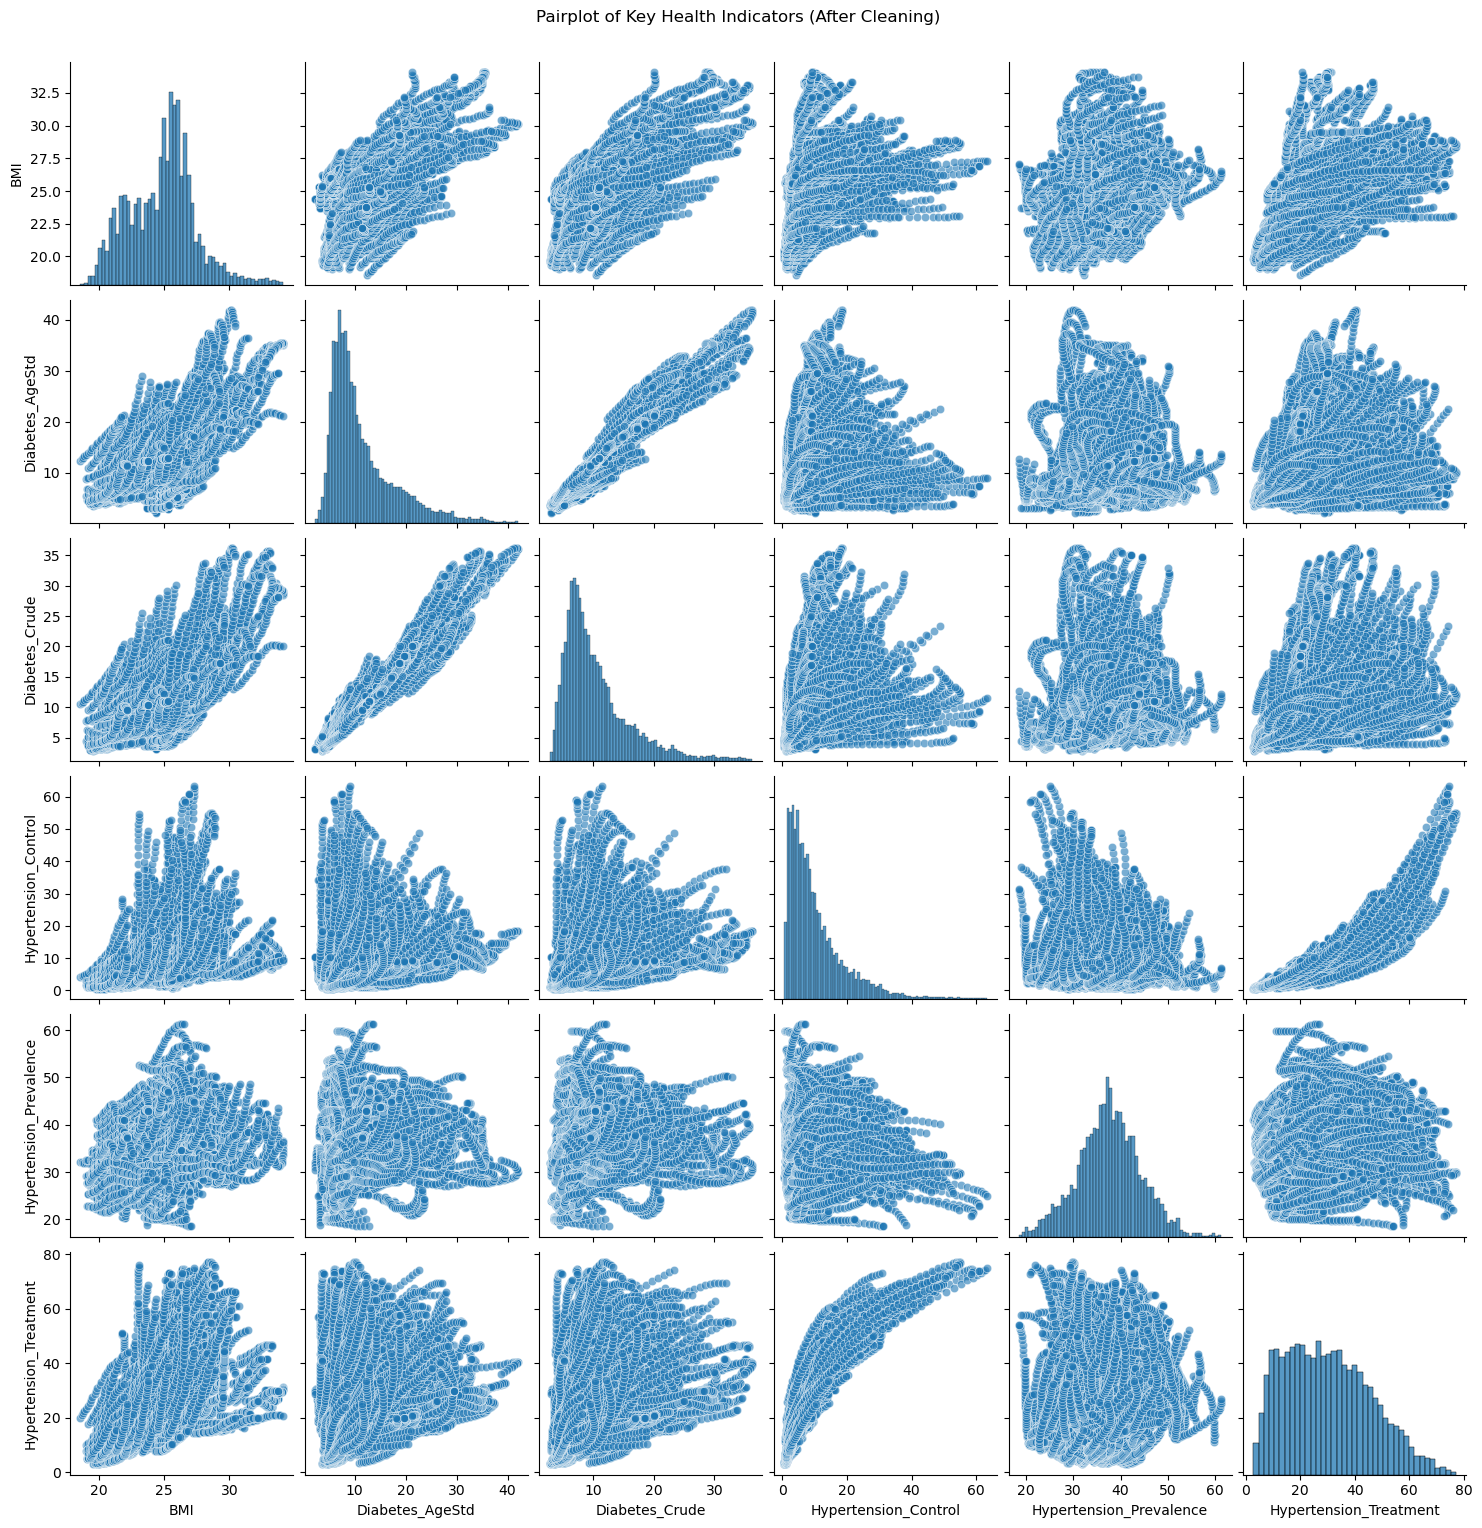

In [13]:
data = pd.read_csv("data/processed-data/who_pivoted_data_with_classes.csv")

numeric_columns = ['BMI', 'Diabetes_AgeStd', 'Diabetes_Crude', 
                   'Hypertension_Control', 'Hypertension_Prevalence', 
                   'Hypertension_Treatment']

# Create pairplot
sns.pairplot(data[numeric_columns], diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot of Key Health Indicators (After Cleaning)", y=1.02)
plt.show()

The pairplot provides a comprehensive visualization of the relationships among key health indicators, including BMI, Diabetes Age-Standardized, Diabetes Crude, Hypertension Control, Hypertension Prevalence, and Hypertension Treatment, after data cleaning and preprocessing. The diagonal plots display the distribution of individual features, while the scatterplots on the off-diagonal represent the pairwise relationships between variables. While the plot reveals dense clusters and suggests strong correlations, particularly between `Hypertension_Control` and `Hypertension_Treatment`, the visualization is cluttered due to overlapping points, making detailed patterns difficult to discern.

To address these issues and improve clarity, several steps will be taken. First, the opacity of points in the scatterplots will be reduced by introducing transparency, minimizing the impact of overlaps. Additionally, subsampling the data or focusing on specific regions or demographic groups will allow for more targeted analyses. Transformations, such as normalization or logarithmic scaling, will also be applied to features with a wide range to highlight subtle patterns. Finally, instead of visualizing all pairwise combinations, specific scatterplots will be created for highly correlated features like `BMI` and `Diabetes_Crude` to better understand these key relationships. These enhancements will make the visualizations more interpretable and valuable for further analysis.

# Reference